In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('OutputFeatures.csv')
features_to_disregard = ['Feature1', 'Feature6', 'Feature7', 'Feature8', 'Feature15']
df = df.drop(columns=features_to_disregard)

In [43]:
categorical_features = ['Feature0', 'Feature3', 'Feature5']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded.head()

,Target1,Feature2,Feature4,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature0_UE,Feature0_US,Feature0_YS,Feature3_plate,Feature5_radial,Feature5_transverse
0,568.0,18.9,100,979,111,739,222,600,1000,False,False,True,False,False,False
1,479.0,300.0,100,979,111,739,222,600,1000,False,False,True,False,False,False
2,453.0,400.0,100,979,111,739,222,600,1000,False,False,True,False,False,False
3,404.0,500.0,100,979,111,739,222,600,1000,False,False,True,False,False,False
4,284.0,600.0,100,979,111,739,222,600,1000,False,False,True,False,False,False


In [5]:
y_unscaled = df_encoded['Target1']
X_unscaled= df_encoded.drop(columns=['Target1'])

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X_unscaled)
y = scaler_y.fit_transform(y_unscaled.values.reshape(-1, 1)).flatten()

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

print(f"X tensor shape: {X.shape}")
print(f"y tensor shape: {y.shape}")

NumberFeatures = X.shape[1]

X tensor shape: torch.Size([530, 14])
y tensor shape: torch.Size([530, 1])


In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size1)
        self.fc4 = nn.Linear(hidden_size1, output_size)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
from sklearn.model_selection import KFold

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [8]:
def kfold_trian(dataset, kf, model, criterion, optimizer, epochs=30, batch_size=32, mute=False):
    TrainLoss = []
    ValLoss = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
    
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            # Prepare data for this fold
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
    
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
            # Training phase
            fold_train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                loss.backward()
                optimizer.step()
                fold_train_loss += loss.item()
            total_train_loss += fold_train_loss / len(train_loader)
    
            # Validation phase
            model.eval()
            fold_val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    predictions = model(batch_X)
                    loss = criterion(predictions, batch_y)
                    fold_val_loss += loss.item()
            total_val_loss += fold_val_loss / len(val_loader)
            
        if not mute:
            if (epoch + 1) % 1 == 0:
                avg_train_loss = total_train_loss / num_folds
                avg_val_loss = total_val_loss / num_folds
                print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            
        if (epoch + 1) % 1 == 0:
            TrainLoss.append(total_train_loss / num_folds)
            ValLoss.append(total_val_loss / num_folds)
            
    return model, TrainLoss, ValLoss

In [9]:
learning_rate = 5e-4
weight_decay = 1e-5
hidden_size1=32
hidden_size2=32

model = Model(input_size=NumberFeatures, hidden_size1=hidden_size1, hidden_size2=hidden_size2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model, TrainLoss, ValLoss = kfold_trian(train_dataset, kf, model, criterion, optimizer)

Epoch [1/30] - Train Loss: 0.9127, Val Loss: 0.8959
Epoch [2/30] - Train Loss: 0.5140, Val Loss: 0.4575
Epoch [3/30] - Train Loss: 0.1278, Val Loss: 0.1096
Epoch [4/30] - Train Loss: 0.0469, Val Loss: 0.0435
Epoch [5/30] - Train Loss: 0.0275, Val Loss: 0.0276
Epoch [6/30] - Train Loss: 0.0207, Val Loss: 0.0212
Epoch [7/30] - Train Loss: 0.0168, Val Loss: 0.0171
Epoch [8/30] - Train Loss: 0.0146, Val Loss: 0.0141
Epoch [9/30] - Train Loss: 0.0121, Val Loss: 0.0126
Epoch [10/30] - Train Loss: 0.0110, Val Loss: 0.0111
Epoch [11/30] - Train Loss: 0.0100, Val Loss: 0.0102
Epoch [12/30] - Train Loss: 0.0089, Val Loss: 0.0091
Epoch [13/30] - Train Loss: 0.0083, Val Loss: 0.0088
Epoch [14/30] - Train Loss: 0.0077, Val Loss: 0.0080
Epoch [15/30] - Train Loss: 0.0073, Val Loss: 0.0075
Epoch [16/30] - Train Loss: 0.0067, Val Loss: 0.0071
Epoch [17/30] - Train Loss: 0.0065, Val Loss: 0.0065
Epoch [18/30] - Train Loss: 0.0061, Val Loss: 0.0062
Epoch [19/30] - Train Loss: 0.0059, Val Loss: 0.0061
Ep

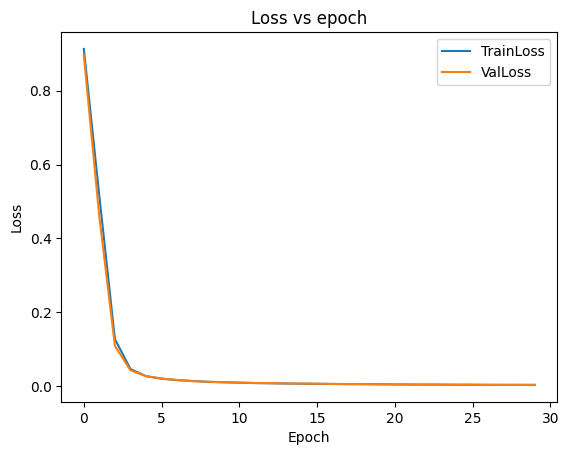

In [10]:
plt.plot(TrainLoss, label = "TrainLoss")
plt.plot(ValLoss, label = "ValLoss")
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
model.eval()
test_loss = 0
Pred=[]
with torch.no_grad():
    for test_X, test_y in test_dataset:
        predictions = model(test_X)
        loss = criterion(predictions, test_y)
        test_loss += loss.item()
        Pred.append(scaler_y.inverse_transform([predictions.detach().numpy()])[0][0])

print(f'Test Loss: {test_loss / len(test_dataset):.4f}')

Test Loss: 0.0127


In [12]:
x_test, y_test = zip(*test_dataset)
y_test = torch.tensor(y_test)
x_test = torch.stack(x_test)

y_test_original = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()
x_test_original = scaler_X.inverse_transform(x_test.numpy())

colors = []
for row in x_test_original.T[9:12].T:
    if row[0] == 1:
        colors.append(1)
    elif row[1] == 1:
        colors.append(2)
    elif row[2] == 1:
        colors.append(3)
    else:
        colors.append(4)

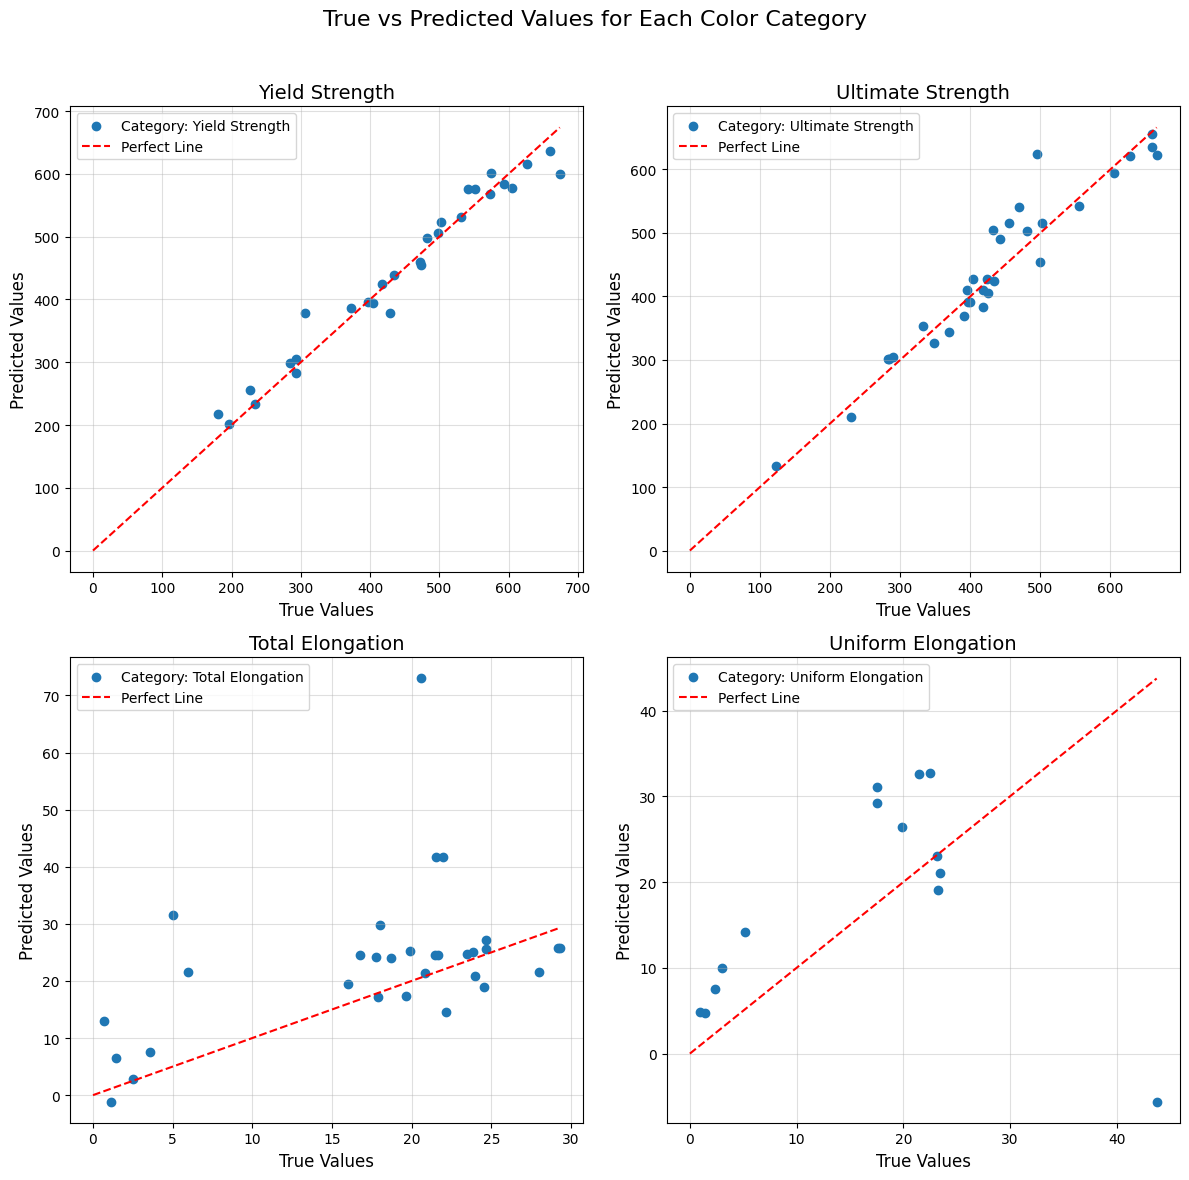

In [13]:
unique_colors = np.unique(colors)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("True vs Predicted Values for Each Color Category", fontsize=16)

TargetLabels = ["Yield Strength", "Ultimate Strength", "Total Elongation", "Uniform Elongation"]
for i, color in enumerate(unique_colors):
    ax = axs[i // 2, i % 2]
    mask = colors == color 
    ax.scatter(
        y_test_original[mask],
        np.array(Pred)[mask],
        label=f"Category: {TargetLabels[i]}",
        marker="o",
    )
    ax.plot([0, max(y_test_original[mask])], [0, max(y_test_original[mask])], color="red", linestyle="--", label="Perfect Line")
    ax.set_title(f"{TargetLabels[i]}", fontsize=14)
    ax.set_xlabel("True Values", fontsize=12)
    ax.set_ylabel("Predicted Values", fontsize=12)
    ax.grid(alpha=0.4)
    ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
param_grid = {
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'weight_decay': [1e-5, 1e-6],
    'hidden_size1': [32, 64],
    'hidden_size2': [32, 64]
}

In [35]:
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid(param_grid)

bestscore = 1
GridScore_train = []
GridScore_test = []
for params in grid:
    print(params)
    model = Model(input_size=NumberFeatures, hidden_size1=params["hidden_size1"], hidden_size2=params["hidden_size2"], output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
    
    model, TrainLoss, ValLoss = kfold_trian(train_dataset, kf, model, criterion, optimizer, mute=True)
    
    model.eval()
    test_loss = 0
    train_loss = 0
    with torch.no_grad():
        for test_X, test_y in test_dataset:
            predictions = model(test_X)
            loss = criterion(predictions, test_y)
            test_loss += loss.item()
        for train_X, train_y in train_dataset:
            predictions = model(train_X)
            loss = criterion(predictions, train_y)
            train_loss += loss.item()
    
    print(f'Test Loss: {test_loss / len(test_dataset):.4f}')
    print(f'Train Loss: {train_loss / len(train_dataset):.4f}')
    GridScore_train.append(train_loss / len(train_dataset))
    GridScore_test.append(test_loss / len(test_dataset))
    if test_loss / len(test_dataset) < bestscore:
        bestparams = params
        bestscore = test_loss / len(test_dataset)

{'hidden_size1': 32, 'hidden_size2': 32, 'learning_rate': 0.001, 'weight_decay': 1e-05}
Test Loss: 0.0132
Train Loss: 0.0038
{'hidden_size1': 32, 'hidden_size2': 32, 'learning_rate': 0.001, 'weight_decay': 1e-06}
Test Loss: 0.0099
Train Loss: 0.0030
{'hidden_size1': 32, 'hidden_size2': 32, 'learning_rate': 0.0005, 'weight_decay': 1e-05}
Test Loss: 0.0111
Train Loss: 0.0031
{'hidden_size1': 32, 'hidden_size2': 32, 'learning_rate': 0.0005, 'weight_decay': 1e-06}
Test Loss: 0.0124
Train Loss: 0.0037
{'hidden_size1': 32, 'hidden_size2': 32, 'learning_rate': 0.0001, 'weight_decay': 1e-05}
Test Loss: 0.0188
Train Loss: 0.0110
{'hidden_size1': 32, 'hidden_size2': 32, 'learning_rate': 0.0001, 'weight_decay': 1e-06}
Test Loss: 0.0311
Train Loss: 0.0206
{'hidden_size1': 32, 'hidden_size2': 64, 'learning_rate': 0.001, 'weight_decay': 1e-05}
Test Loss: 0.0129
Train Loss: 0.0028
{'hidden_size1': 32, 'hidden_size2': 64, 'learning_rate': 0.001, 'weight_decay': 1e-06}
Test Loss: 0.0165
Train Loss: 0.0

In [39]:
bestparams, bestscore

({'hidden_size1': 64,
  'hidden_size2': 64,
  'learning_rate': 0.0005,
  'weight_decay': 1e-05},
 0.009459740515138012)

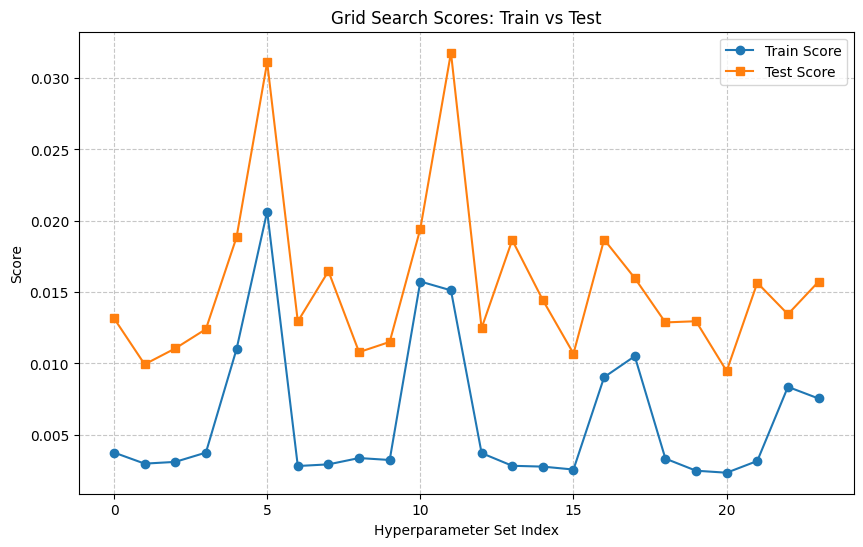

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(GridScore_train, label='Train Score', marker='o')
plt.plot(GridScore_test, label='Test Score', marker='s')
plt.xlabel("Hyperparameter Set Index")
plt.ylabel("Score")
plt.title("Grid Search Scores: Train vs Test")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [37]:
[params.values() for params, score in zip(grid, GridScore_train) if score < 0.005]

[dict_values([32, 32, 0.001, 1e-05]),
 dict_values([32, 32, 0.001, 1e-06]),
 dict_values([32, 32, 0.0005, 1e-05]),
 dict_values([32, 32, 0.0005, 1e-06]),
 dict_values([32, 64, 0.001, 1e-05]),
 dict_values([32, 64, 0.001, 1e-06]),
 dict_values([32, 64, 0.0005, 1e-05]),
 dict_values([32, 64, 0.0005, 1e-06]),
 dict_values([64, 32, 0.001, 1e-05]),
 dict_values([64, 32, 0.001, 1e-06]),
 dict_values([64, 32, 0.0005, 1e-05]),
 dict_values([64, 32, 0.0005, 1e-06]),
 dict_values([64, 64, 0.001, 1e-05]),
 dict_values([64, 64, 0.001, 1e-06]),
 dict_values([64, 64, 0.0005, 1e-05]),
 dict_values([64, 64, 0.0005, 1e-06])]